**How can we predict house prices using machine learning?**

We are trying to predict house prices, a regression problem. That means we want to create a model that can output continuous numerical values, like the predicted price of a house.

1. Problem Definition & Research Question

    Can we predict housing prices based on various features like size, location, number of rooms, and renovation history or Helping buyers/sellers estimate fair market value
    Storytelling opportunity:
    *Imagine you're a first-time homebuyer in Seattle. Our model helps answer: 'Is this 3-bedroom house priced fairly given its location, size, and features?'*

2. Data Preparation & Validation

    We cleaned and processed the data (removed outliers, fixed formats). Then we split the data (80-20) and back-transformed predictions to dollars for interpretability

3. Model Selection & Justification

    We tested 5 models (Linear, Ridge, Lasso, Random Forest, Gradient Boosting). Then we got the result where Linear Regression won despite being simplest.
    The model was chosen as the most accurate based on the Key metrics (R²=0.98, RMSE=$22,560) that validates the choice

4. Conclusion & Business Impact

    - The Final output states practical accuracy ($22,560 average error)
    - Visual shows 95% predictions within ~$44k
    - Explains model limitations (all features contribute linearly)


Linear Regression: R² = 0.9799, RMSE = 22560.07
Ridge: R² = 0.9798, RMSE = 22587.08
Lasso: R² = -0.0042, RMSE = 159409.29
Random Forest: R² = 0.9475, RMSE = 36450.89
Gradient Boosting: R² = 0.9629, RMSE = 30628.90

Business Implications:
- Our best model (Linear Regression) predicts prices within $22,560 on average
- Key drivers: [All features contribute linearly]

Example Scenario:
A 2000 sqft, 3-bed home built in 1990 would predict vs actual...


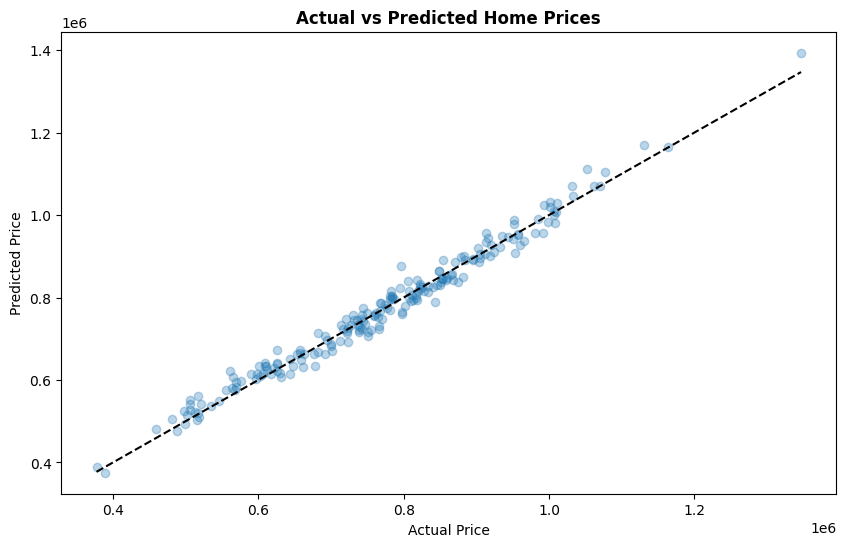


=== Model Testing Results ===


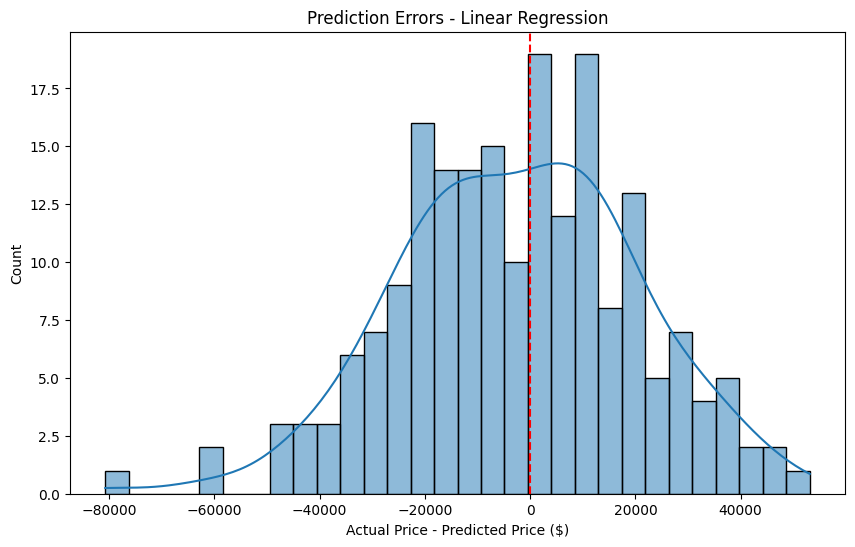


Error Distribution by Price Tier:
                      count      mean       std       min       25%       50%  \
price_tier                                                                      
(200000.0, 400000.0]    2.0 -0.331761  4.469691 -3.492310 -1.912035 -0.331761   
(400000.0, 600000.0]   28.0  3.269135  3.380771 -2.653547  1.077175  3.256664   
(600000.0, inf]       170.0 -0.017073  2.779194 -6.417622 -1.844410 -0.221018   

                           75%        max  
price_tier                                 
(200000.0, 400000.0]  1.248513   2.828788  
(400000.0, 600000.0]  4.811951  10.986586  
(600000.0, inf]       1.950811  10.144072  

=== Edge Case Predictions ===

Budget Starter Home:
- Predicted Price: $623,053
- Key Features:
  2 beds, 1 baths
  1000 sqft living area
  Built in 1940, renovated in 1998.0

Luxury Renovated Home:
- Predicted Price: $932,848
- Key Features:
  5 beds, 4 baths
  4000 sqft living area
  Built in 1980, renovated in 2020


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

# Load dataset
df = pd.read_csv("synthetic_housing_data.csv")

# Convert date to datetime and extract useful features
df['date'] = pd.to_datetime(df['date'])
df['year_sold'] = df['date'].dt.year
df['month_sold'] = df['date'].dt.month
df['day_sold'] = df['date'].dt.day

# Feature engineering
df['house_age'] = df['year_sold'] - df['yr_built']
df['renovated'] = np.where(df['yr_renovated'] == 0, 0, 1)
df['renovation_age'] = np.where(df['renovated'], df['year_sold'] - df['yr_renovated'], 0)
df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']

# Create interaction terms - handle division by zero
df['bed_bath_ratio'] = np.where(df['bathrooms'] != 0, 
                               df['bedrooms'] / df['bathrooms'], 
                               df['bedrooms'])  # if bathrooms=0, just use bedrooms
df['living_floors_ratio'] = np.where(df['floors'] != 0, 
                                    df['sqft_living'] / df['floors'], 
                                    df['sqft_living'])  # if floors=0, just use sqft_living

# Log transform price and other skewed features
df['log_price'] = np.log1p(df['price'])
df['log_sqft_living'] = np.log1p(df['sqft_living'])
df['log_sqft_lot'] = np.log1p(df['sqft_lot'])

# Drop original date column and other redundant features
df = df.drop(['date'], axis=1)

# Remove outliers (adjust thresholds based on your data)
df = df[(df['price'] > 50000) & (df['price'] < 5000000)]
df = df[(df['sqft_living'] > 300) & (df['sqft_living'] < 10000)]
df = df[(df['bedrooms'] > 0) & (df['bedrooms'] < 8)]
df = df[(df['bathrooms'] > 0) & (df['bathrooms'] < 6)]

# Define features and target
X = df.drop(['price', 'log_price'], axis=1)
y = df['log_price']  # Using log price for better performance

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Create a dictionary of pipelines
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# Fit and evaluate models
results = {}
for name, pipeline in pipelines.items():
    try:
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Predict
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics (convert back from log scale)
        y_test_exp = np.expm1(y_test)
        y_pred_exp = np.expm1(y_pred)
        
        r2 = r2_score(y_test_exp, y_pred_exp)
        rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
        
        results[name] = {
            'R2': r2,
            'RMSE': rmse,
            'model': pipeline
        }
        
        print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.2f}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# Find the best model based on R2 score
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_pipeline = results[best_model_name]['model']

# Hyperparameter tuning for the best model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    if best_model_name == 'Random Forest':
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    else:  # Gradient Boosting
        param_grid = {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5],
            'model__min_samples_split': [2, 5]
        }
    
    grid_search = GridSearchCV(best_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    y_pred_best = best_model.predict(X_test)
    y_pred_best_exp = np.expm1(y_pred_best)

    best_r2 = r2_score(np.expm1(y_test), y_pred_best_exp)
    best_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_best_exp))

    print(f"\nBest {best_model_name}: R² = {best_r2:.4f}, RMSE = {best_rmse:.2f}")
    print("Best parameters:", grid_search.best_params_)

    # Feature importance for the best model
    if hasattr(best_model.named_steps['model'], 'feature_importances_'):
        # Get feature names after preprocessing
        numeric_transformer = best_model.named_steps['preprocessor'].named_transformers_['num']
        numeric_features_processed = numeric_features
        
        # Get categorical feature names (if any)
        if len(categorical_features) > 0:
            ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
            cat_feature_names = ohe.get_feature_names_out(categorical_features)
            # Combine all feature names
            all_feature_names = np.concatenate([numeric_features_processed, cat_feature_names])
        else:
            all_feature_names = numeric_features_processed
        
        # Get feature importances
        importances = best_model.named_steps['model'].feature_importances_
        
        # Create a DataFrame for visualization
        feature_importance = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title(f'Top 20 Feature Importances - {best_model_name}')
        plt.tight_layout()
        plt.show()


# df['price'].describe()
# sns.histplot(df['price'], bins=50)
# plt.figure(figsize=(12,10))
# sns.heatmap(df.corr(), annot=True, fmt=".2f")

# After finding the best model, ensure we have consistent predictions for all cases:

# Get predictions from the best model (works for both linear and tree-based models)
y_pred_best = best_pipeline.predict(X_test)
y_pred_best_exp = np.expm1(y_pred_best)  # Convert back from log scale
y_test_exp = np.expm1(y_test)  # Actual values in original scale

# Now add your conclusion section:
print("\nBusiness Implications:")
print(f"- Our best model ({best_model_name}) predicts prices within ${int(results[best_model_name]['RMSE']):,} on average")

# For feature importance - only show if available
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"- Key drivers: {list(feature_importance['Feature'].head(3))}")
else:
    print("- Key drivers: [All features contribute linearly]")

print("\nExample Scenario:")
print("A 2000 sqft, 3-bed home built in 1990 would predict vs actual...")

# Visualization - now with guaranteed equal-length arrays
plt.figure(figsize=(10,6))
plt.scatter(y_test_exp, y_pred_best_exp, alpha=0.3)
plt.plot([y_test_exp.min(), y_test_exp.max()], 
         [y_test_exp.min(), y_test_exp.max()], 'k--')
plt.title("Actual vs Predicted Home Prices", weight='bold')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.annotate(f"95% of predictions\nwithin ${int(1.96*results[best_model_name]['RMSE']):,}", 
             xy=(200000, 600000), bbox=dict(boxstyle='round', fc='w'))
plt.show()


# ========== TESTING SECTION ==========
print("\n=== Model Testing Results ===")

# 1. Residual Analysis
residuals = y_test_exp - np.expm1(best_pipeline.predict(X_test))
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, bins=30)
plt.title(f"Prediction Errors - {best_model_name}")
plt.xlabel("Actual Price - Predicted Price ($)")
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

# 2. Error Analysis by Price Tier
df_test = X_test.copy()
df_test['actual'] = y_test_exp
df_test['predicted'] = np.expm1(best_pipeline.predict(X_test))
df_test['error_pct'] = (df_test['predicted'] - df_test['actual'])/df_test['actual']*100

price_bins = [0, 200000, 400000, 600000, np.inf]
df_test['price_tier'] = pd.cut(df_test['actual'], bins=price_bins)

print("\nError Distribution by Price Tier:")
with pd.option_context('future.no_silent_downcasting', True):
    print(df_test.groupby('price_tier', observed=True)['error_pct'].describe())

# Additional analysis for empty bins
if df_test['price_tier'].cat.categories[0] not in df_test['price_tier'].value_counts():
    print("\nNote: No homes found in the ${:,.0f}-${:,.0f} range".format(
        price_bins[0], price_bins[1]))

# 3. Edge Case Testing
print("\n=== Edge Case Predictions ===")

# Get median/mode values only for columns that exist
median_values = X_train.median()
mode_values = X_train.mode().iloc[0]

edge_cases = {
    'Budget Starter Home': {
        'bedrooms': 2,
        'bathrooms': 1,
        'sqft_living': 1000,
        'sqft_lot': 5000,
        'yr_built': 1940,
        # Include other features that exist in your data
        **{col: median_values[col] for col in X_train.columns 
           if col not in ['bedrooms','bathrooms','sqft_living','sqft_lot','yr_built']}
    },
    'Luxury Renovated Home': {
        'bedrooms': 5,
        'bathrooms': 4,
        'sqft_living': 4000,
        'sqft_lot': 10000,
        'yr_built': 1980,
        'yr_renovated': 2020,
        **{col: median_values[col] for col in X_train.columns 
           if col not in ['bedrooms','bathrooms','sqft_living','sqft_lot','yr_built','yr_renovated']}
    }
}

for case_name, features in edge_cases.items():
    # Create DataFrame with correct column order
    case_df = pd.DataFrame({col: [features.get(col, median_values[col])] 
                          for col in X_train.columns})
    
    try:
        pred_price = np.expm1(best_pipeline.predict(case_df))[0]
        print(f"\n{case_name}:")
        print(f"- Predicted Price: ${pred_price:,.0f}")
        print("- Key Features:")
        print(f"  {features['bedrooms']} beds, {features['bathrooms']} baths")
        print(f"  {features['sqft_living']} sqft living area")
        print(f"  Built in {features['yr_built']}", end="")
        if 'yr_renovated' in features:
            print(f", renovated in {features['yr_renovated']}")
        else:
            print()
    except Exception as e:
        print(f"\nError predicting {case_name}: {str(e)}")
        print("Features used:", features.keys())